# <center><u> Projet N°10 : Détection de faux billets avec Python </u></center>

<center>
<img width="300" height="100" src="./ONCFM.jpg"/>
</center>

## 0. Importation des données, paramétrage de l'environnement et définitition de fonctions.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import Logit
from scipy.stats import shapiro
from scipy import stats

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import random
import warnings as warn

# pour supprimer l'avertissement d'une future dépréciation de 'KMeans
warn.filterwarnings('ignore', category = UserWarning, module = 'sklearn.cluster.KMeans')

In [2]:
# fonction destinée à l'identification automatisée des vrais et faux billets
def detection(nom_fichier_test):
    
    test = pd.read_csv(nom_fichier_test, sep = ";")
    test_bis = test.copy()
    id = test['id']
    test_bis = test.drop('id', axis = 1)
    test_bis = add_constant(test_bis)
    prediction = res.predict(test_bis)
    test['is_genuine'] = prediction
    test.loc[test['is_genuine'] > 0.5, 'is_genuine'] = "True"
    test.loc[test['is_genuine'] != "True", 'is_genuine'] = "False"
    test['logit'] = prediction
    print("Résultats obtenus par régression logistique.")
    display(test)
    
    test_bis = test_bis.drop('const', axis = 1)
    random.seed(10)
    
    # on suppose su'il y au moins un billet de chaque nature dans l'échantillon
    kmeans = KMeans(n_clusters = 2, init = 'random', max_iter = 30).fit_predict(test_bis)
    labels = pd.Series(kmeans)
    clusters = labels.to_frame()
    clusters = clusters.rename(columns = {0:'clusters'})
    test_bis['id']  = id
    test_bis['is_genuine'] = False
    test_bis['clusters']  = clusters
    clust_false = 0
    clust_true = 1

    # on fait l'hypothèse qu'il y a plus de faux billets dans l'échantillon 
    # et on attribue le cluster 1 aux vrais billets
    if len(test_bis.loc[test_bis['clusters'] == 0]) > len(test_bis.loc[test_bis['clusters'] == 1]):
        clust_false = 0
        clust_true = 1
    else:
        clust_false = 1
        clust_true = 0

    test_bis.loc[test_bis['clusters'] == clust_false, 'is_genuine'] = False
    test_bis.loc[test_bis['clusters'] == clust_true, 'is_genuine'] = True
    test_bis.loc[test_bis['is_genuine'] == 1, 'is_genuine'] = True
    test_bis.loc[test_bis['is_genuine'] == 0, 'is_genuine'] = False
    test_bis.loc[test_bis['is_genuine'] == 1, 'clusters'] = 1
    test_bis.loc[test_bis['is_genuine'] == 0, 'clusters'] = 0
   
    print("Résultats obtenus par clusterisation k-means.")
    display(test_bis)

In [3]:
def fp_fn(mcf):

    mcf = mcf.astype('int')
    billets_fp = mcf[1,0]
    billets_fn = mcf[0,1]
    billets_vn = mcf[0,0]
    billets_vp = mcf[1,1]
    billets = mcf.sum()
    pc_billets_fn = round((billets_fn * 100 / billets),2)
    pc_billets_fp = round((billets_fp * 100 / billets) ,2)
    pc_efficacite = round((billets - billets_fp - billets_fn) * 100 / billets, 2)
    pc_specificite = round(billets_vn * 100 / (billets_fp + billets_vn), 2)
    pc_sensibilite = round(billets_vp * 100 / (billets_vp + billets_fn), 2)
    print(f'% de faux positifs : {pc_billets_fp} %')
    print(f'% de faux négatifs : {pc_billets_fn} %')
    print(f"% d'efficacité : {pc_efficacite} %")
    print(f"% sensibilité : {pc_sensibilite} %")
    print(f"% spécificité : {pc_specificite} %")
    billets_fp = 0
    billets_fn = 0
    billets_vp = 0
    billets_vn = 0
    billets = 0

In [4]:
billets = pd.read_csv('billets.csv', sep = ";")

## 1. Analyse descriptive du dataframe 'billets'.

In [5]:
billets

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [6]:
# skim(billets)
print(billets.info())
billets.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB
None


diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

In [7]:
# création d'un dataframe pour isoler les billets présentant une valeur manquante pour 'margin_low' 
billets_nan = billets.loc[billets['margin_low'].isna(), :].copy()
# création de 3 dataframes pour isoler les billets sans valeurs manquantes 
# (1 pour les vrais billets, 1 pour les faux billets et 1 pour tous les billets)
billets_true_nonan = billets.loc[(billets['is_genuine'] == 1) & (billets['margin_low'].notnull()) , :].copy()
billets_false_nonan = billets.loc[(billets['is_genuine'] == 0) & (billets['margin_low'].notnull()) , :].copy()
billets_nonan = billets.loc[billets['margin_low'].notnull(), :].copy()

### 1.1. Détermination du nombre de vrais et faux billets.

In [8]:
# détermination du nombre de vrais et faux billets
nb_billets = len(billets.index)
nb_billets_true = billets["is_genuine"].sum()
nb_billets_false = nb_billets - nb_billets_true
print(f"Il y a {nb_billets} billets dans la base dont {nb_billets_true} vrais et {nb_billets_false} faux.")

Il y a 1500 billets dans la base dont 1000 vrais et 500 faux.


### 1.2. Répartition des dimensions des billets.

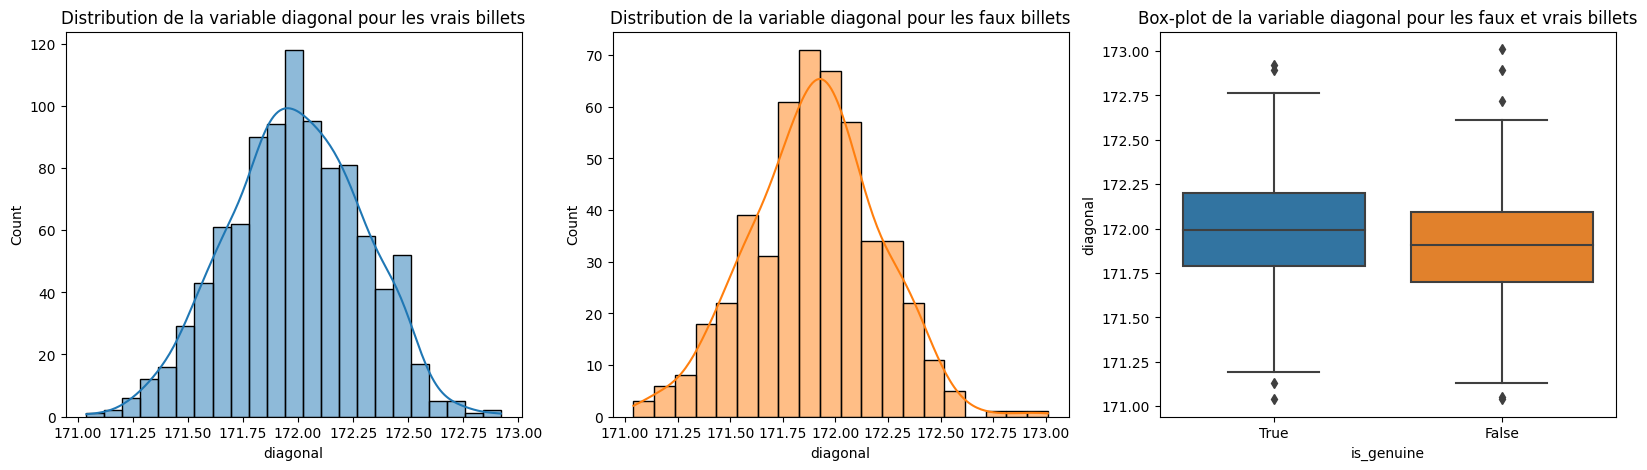

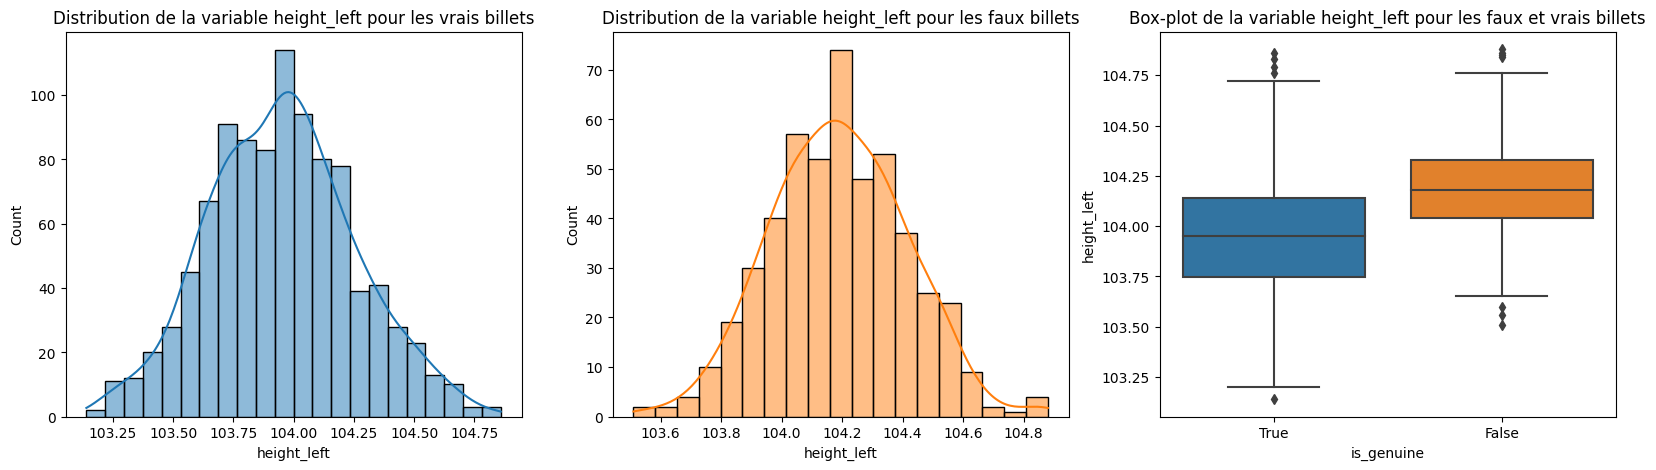

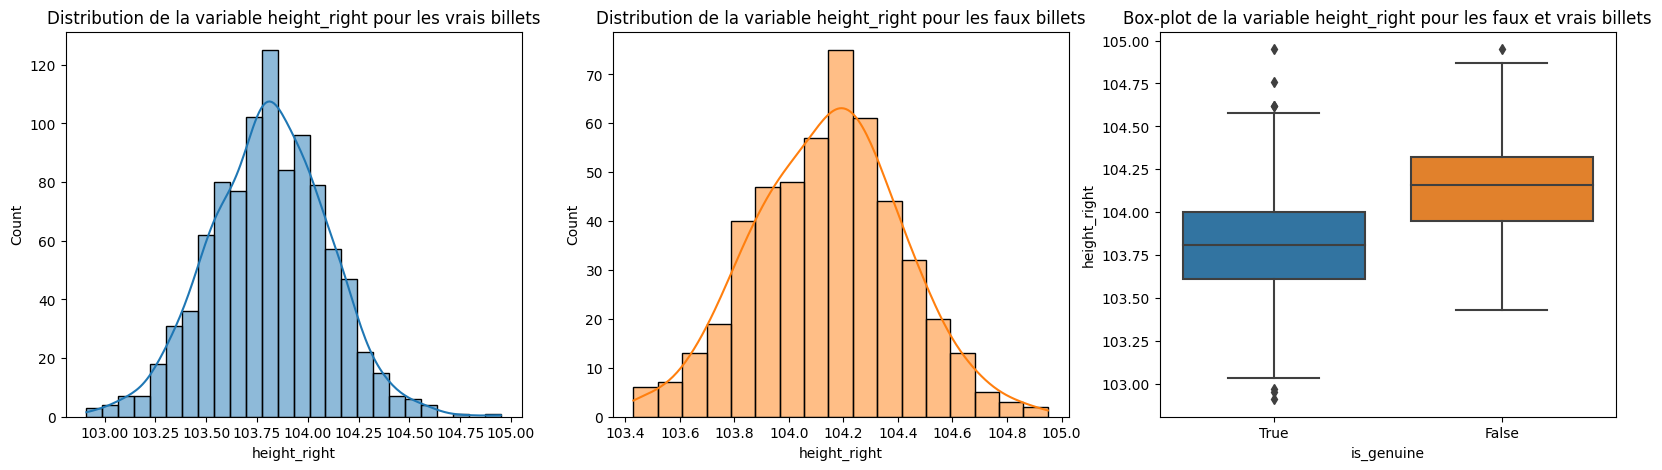

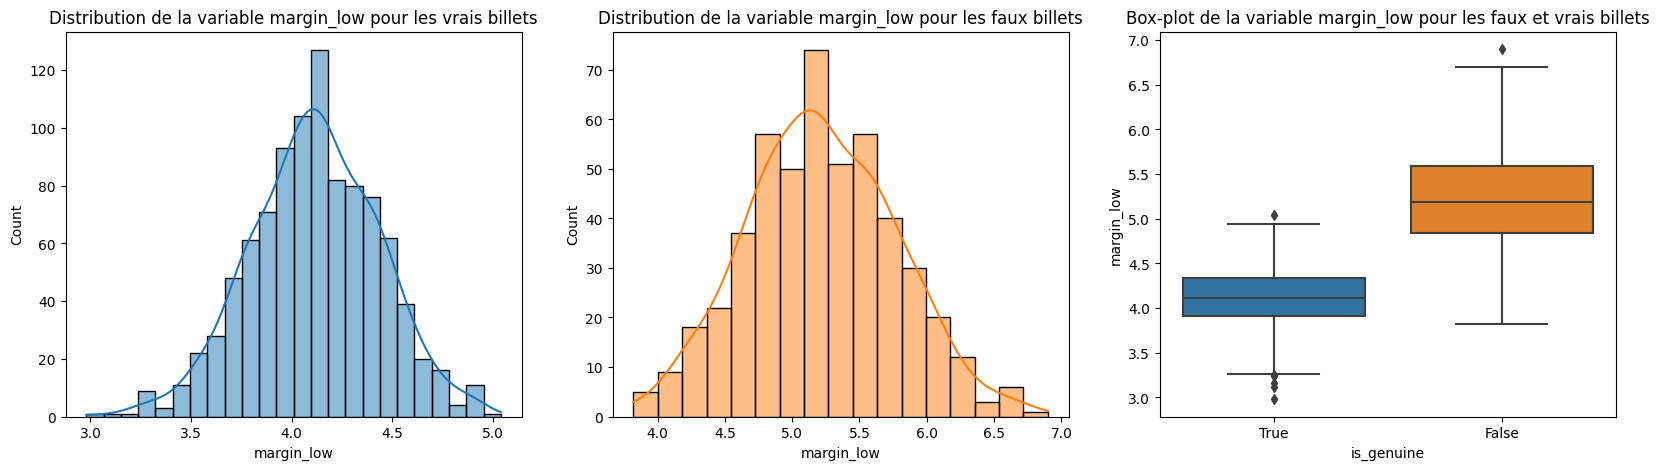

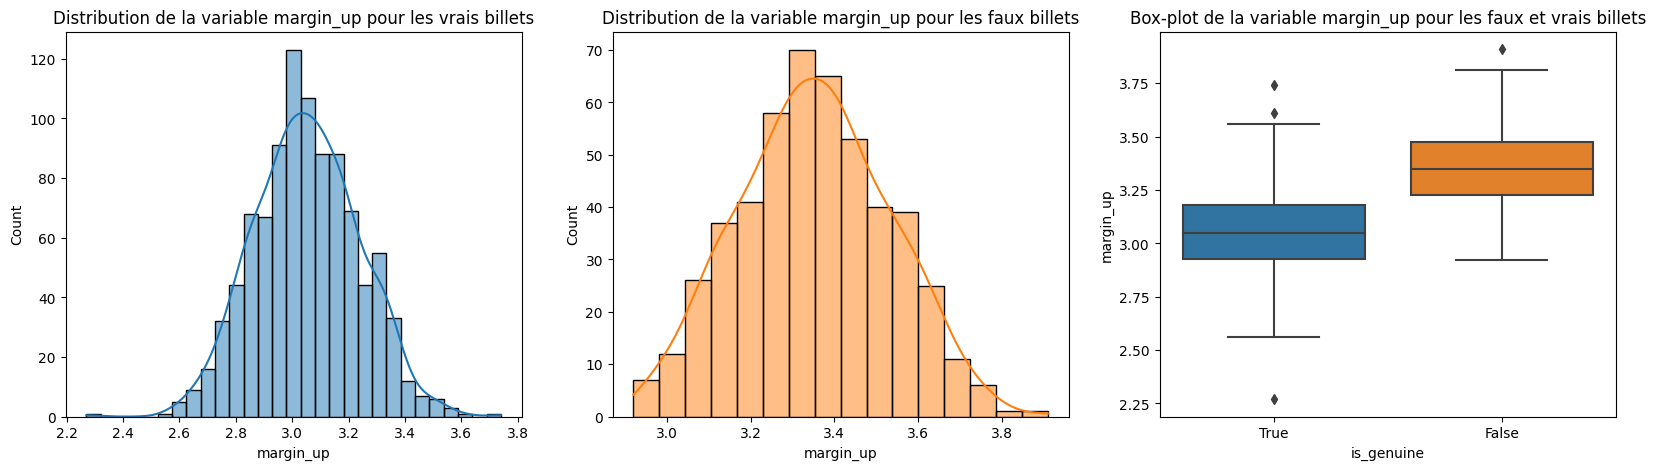

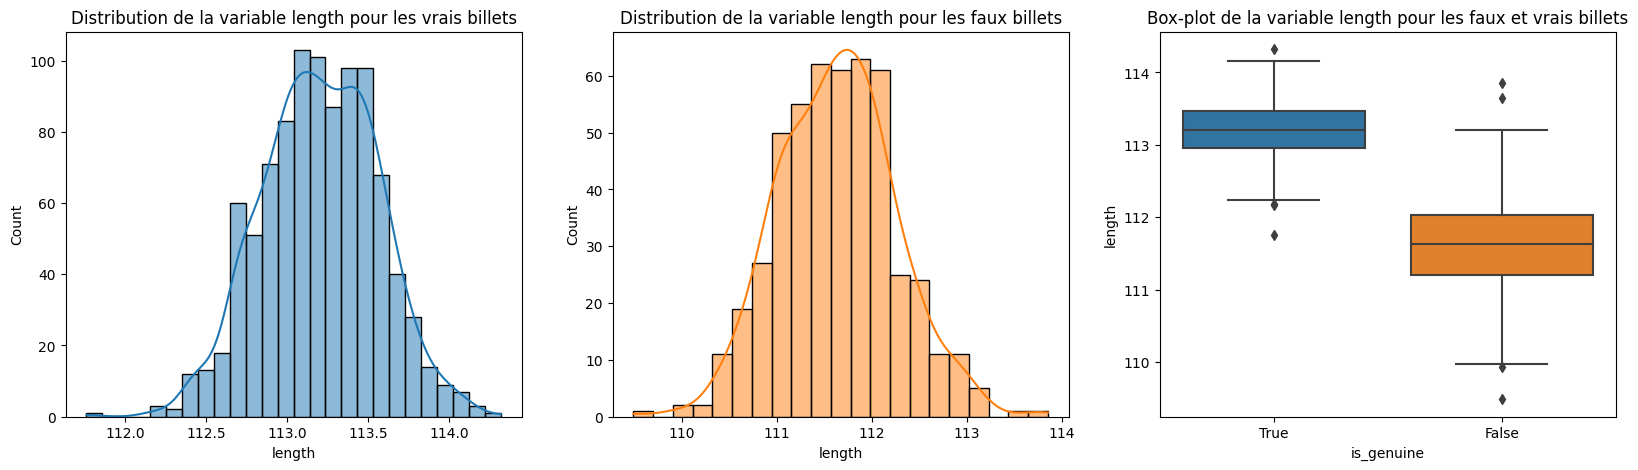

In [9]:
for i in billets_nonan:
    if i != 'is_genuine':
        fig, ax = plt.subplots(1, 3, figsize = (20, 5))
        ax[0].set_title("Distribution de la variable " + i + " pour les vrais billets")
        sns.histplot(data = billets_true_nonan, x = i, kde = True, ax = ax[0], color = '#1f77b4')
        ax[1].set_title("Distribution de la variable " + i + " pour les faux billets")
        sns.histplot(data = billets_false_nonan, x = i, kde = True, ax = ax[1], color = '#ff7f0e')
        ax[2].set_title("Box-plot de la variable " + i + " pour les faux et vrais billets")
        sns.boxplot(y = billets_nonan[i], x = billets_nonan["is_genuine"], order = (True, False), ax = ax[2])
        plt.show()

## 2. Gestion des valeurs manquantes.

### 2.1. Valeurs manquantes pour la variable 'margin_low'.

In [10]:
billets_nan

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45         NaN       3.25   
99          True    171.93       104.07        104.18         NaN       3.14   
151         True    172.07       103.80        104.38         NaN       3.02   
197         True    171.45       103.66        103.80         NaN       3.62   
241         True    171.83       104.14        104.06         NaN       3.02   
251         True    171.80       103.26        102.82         NaN       2.95   
284         True    171.92       103.83        103.76         NaN       3.23   
334         True    171.85       103.70        103.96         NaN       3.00   
410         True    172.56       103.72        103.51         NaN       3.12   
413         True    172.30       103.66        103.50         NaN       3.16   
445         True    172.34       104.42        103.22         NaN       3.01   
481         True    171.81       103.53        103.96         NaN       2.71   
505         True    172.01       103.97        104.05         NaN       2.98   
611         True    171.80       103.68        103.49         NaN       3.30   
654         True    171.97       103.69        103.54         NaN       2.70   
675         True    171.60       103.85        103.91         NaN       2.56   
710         True    172.03       103.97        103.86         NaN       3.07   
739         True    172.07       103.74        103.76         NaN       3.09   
742         True    172.14       104.06        103.96         NaN       3.24   
780         True    172.41       103.95        103.79         NaN       3.13   
798         True    171.96       103.84        103.62         NaN       3.01   
844         True    171.62       104.14        104.49         NaN       2.99   
845         True    172.02       104.21        104.05         NaN       2.90   
871         True    171.37       104.07        103.75         NaN       3.07   
895         True    171.81       103.68        103.80         NaN       2.98   
919         True    171.92       103.68        103.45         NaN       2.58   
945         True    172.09       103.74        103.52         NaN       3.02   
946         True    171.63       103.87        104.66         NaN       3.27   
981         True    172.02       104.23        103.72         NaN       2.99   
1076       False    171.57       104.27        104.44         NaN       3.21   
1121       False    171.40       104.38        104.19         NaN       3.17   
1176       False    171.59       104.05        103.94         NaN       3.02   
1303       False    172.17       104.49        103.76         NaN       2.93   
1315       False    172.08       104.15        104.17         NaN       3.40   
1347       False    171.72       104.46        104.12         NaN       3.61   
1435       False    172.66       104.33        104.41         NaN       3.56   
1438       False    171.90       104.28        104.29         NaN       3.24   

      length  
72    112.79  
99    113.08  
151   112.93  
197   113.27  
241   112.36  
251   113.22  
284   113.29  
334   113.36  
410   112.95  
413   112.95  
445   112.97  
481   113.99  
505   113.65  
611   112.84  
654   112.79  
675   113.27  
710   112.65  
739   112.41  
742   113.07  
780   113.41  
798   114.44  
844   113.35  
845   113.62  
871   113.27  
895   113.82  
919   113.68  
945   112.78  
946   112.68  
981   113.37  
1076  111.87  
1121  112.39  
1176  111.29  
1303  111.21  
1315  112.29  
1347  110.31  
1435  111.47  
1438  111.49

### 2.2. Recherche d'une relation linéaire entre 'margin_low' et les autres variables.

C:\Users\guill\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


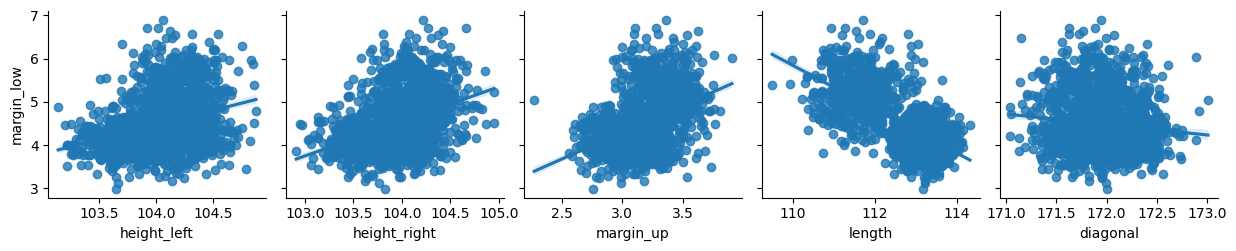

In [11]:
sns.pairplot(billets_nonan, x_vars = ['height_left', 'height_right', 'margin_up', 'length', 'diagonal'],
             y_vars = 'margin_low', kind = 'reg')
plt.show()

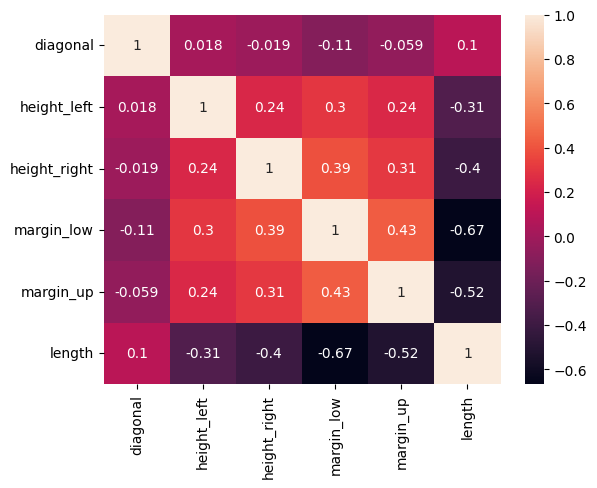

In [12]:
billets_corr = billets_nonan.drop('is_genuine', axis = 1)
corr_mat = billets_corr.corr()
sns.heatmap(corr_mat, annot = True)
plt.show()

In [13]:
# for i in billets_nonan:
#     if (i != 'is_genuine') and (i != 'margin_low'):
#         p = sns.regplot(x = i, y = "margin_low", data = billets_nonan, fit_reg = True, label = True, ci = 95)
#         linreg = stats.linregress(x = p.get_lines()[0].get_xdata(), y = p.get_lines()[0].get_ydata())
#         plt.title("margin_low vs. " + i)
#        plt.show()
#        print('y = ' + str(round(linreg.intercept,3)) + ' + ' + str(round(linreg.slope,3)) + 'x')
#        print(f"R-squared: {linreg.rvalue**2:.6f}")

Variable :  diagonal
Pente :  [[-0.24238327]]
Ordonnée à l'origine :  [46.16599846]
Racine carrée de l'erreur quadratique moyenne :  0.4348681673094168
Sccore R2 :  0.012439850430716826


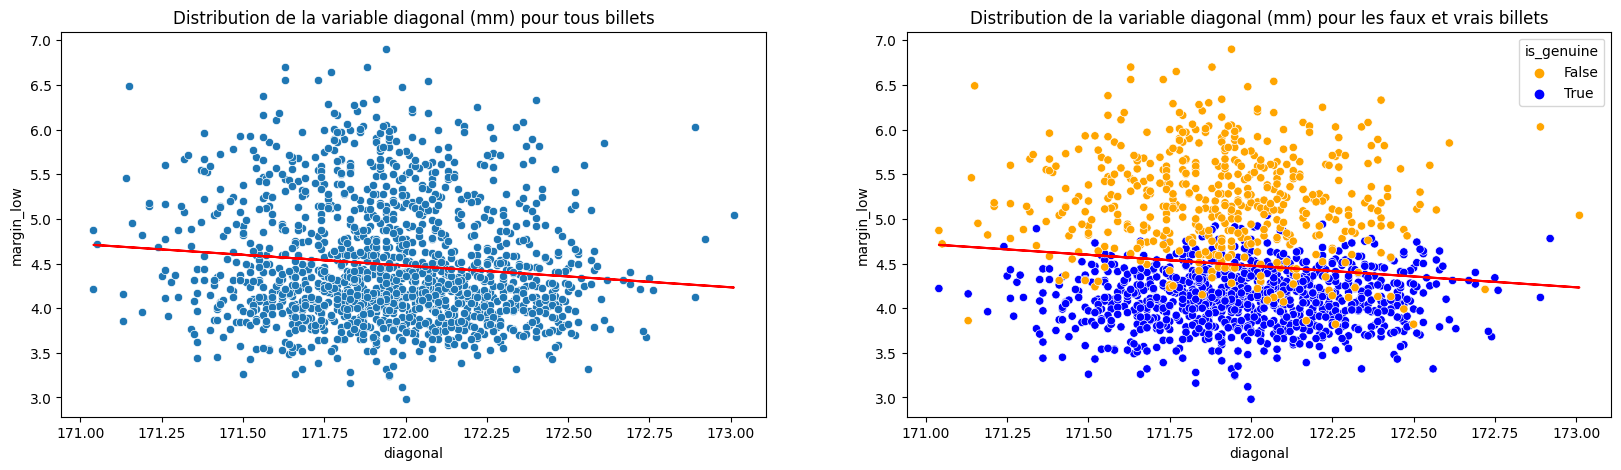

Variable :  height_left
Pente :  [[0.67054267]]
Ordonnée à l'origine :  [-65.27148018]
Racine carrée de l'erreur quadratique moyenne :  0.40001349961489124
Sccore R2 :  0.09159276027592533


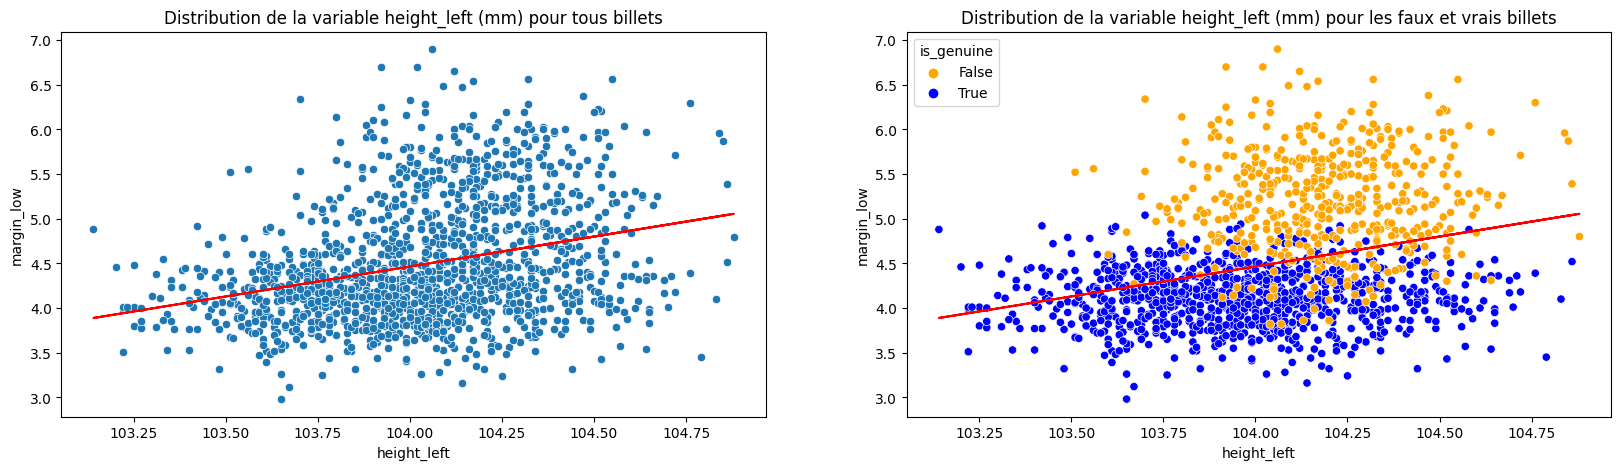

Variable :  height_right
Pente :  [[0.80080914]]
Ordonnée à l'origine :  [-78.73530131]
Racine carrée de l'erreur quadratique moyenne :  0.3729961445257272
Sccore R2 :  0.1529475920124067


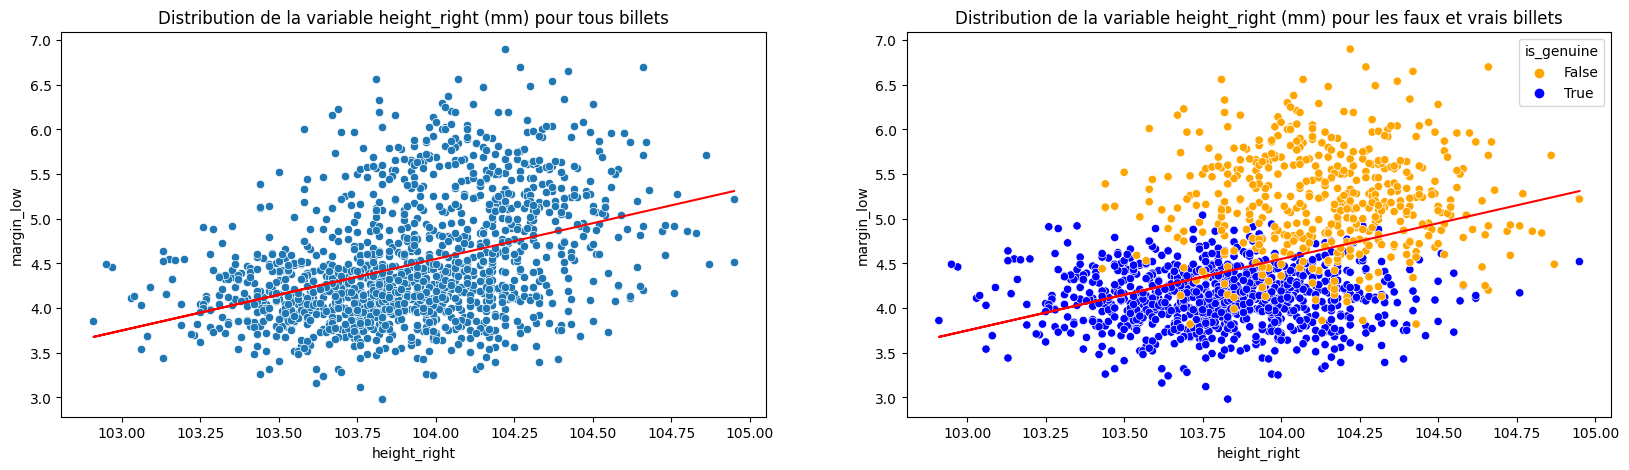

Variable :  margin_up
Pente :  [[1.23778727]]
Ordonnée à l'origine :  [0.58312155]
Racine carrée de l'erreur quadratique moyenne :  0.3583166773784994
Sccore R2 :  0.18628380252698062


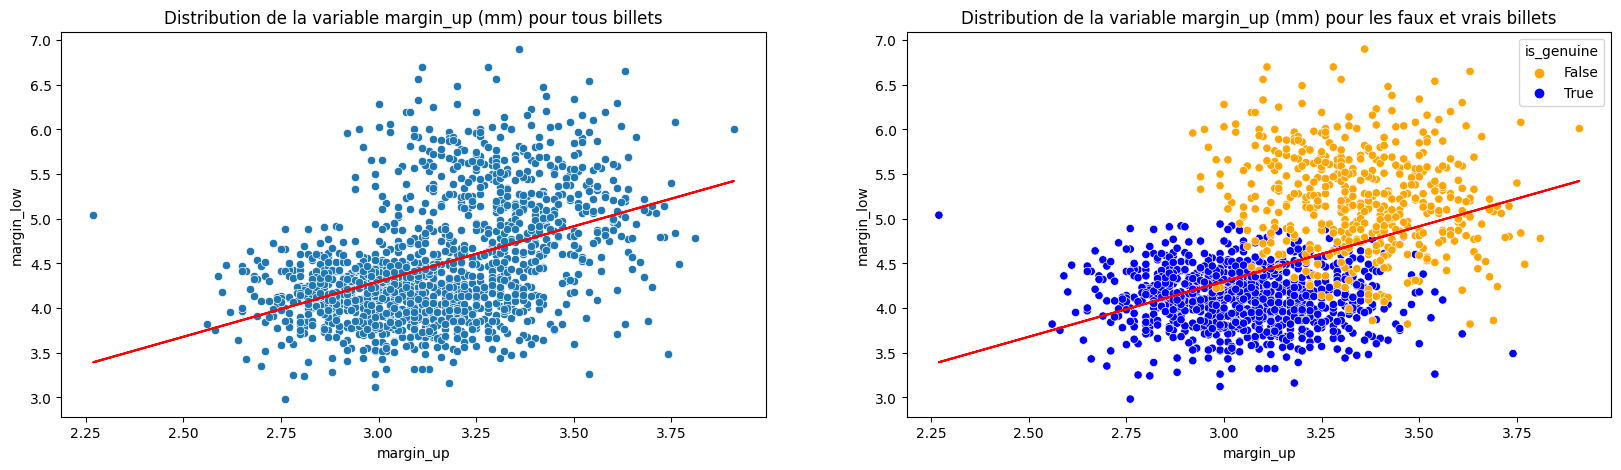

Variable :  length
Pente :  [[-0.50685746]]
Ordonnée à l'origine :  [61.59600862]
Racine carrée de l'erreur quadratique moyenne :  0.24458610652606255
Sccore R2 :  0.44455927082934943


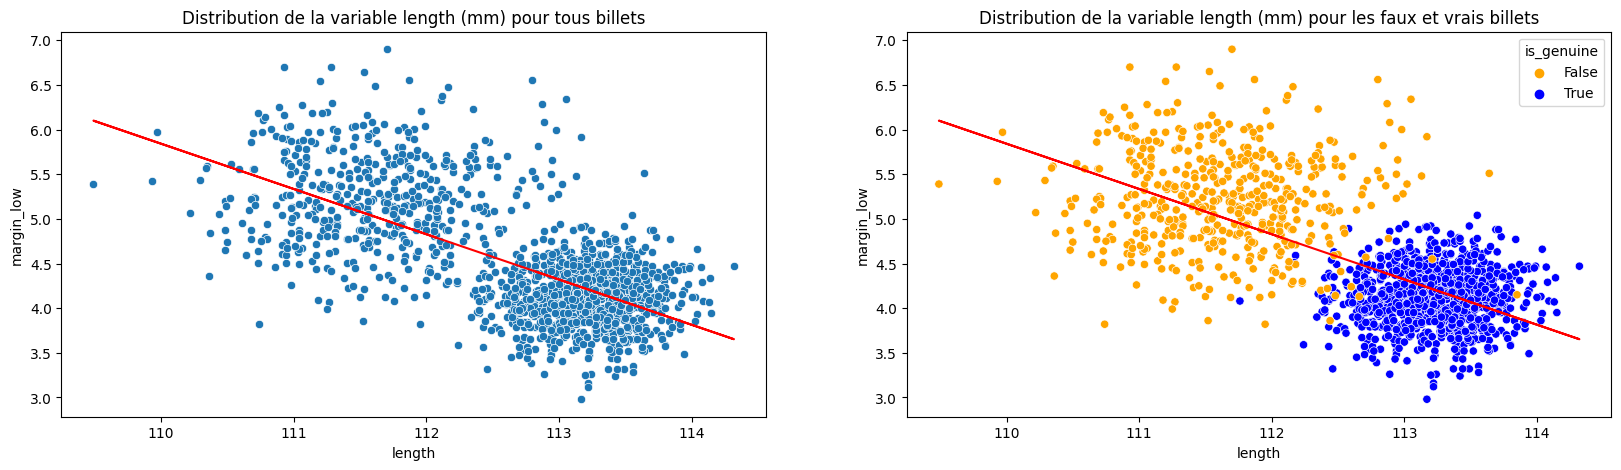

diagonal  height_left  height_right  margin_up     length
pente             -0.242383     0.670543      0.800809   1.237787  -0.506857
ordonnée_origine  46.165998   -65.271480    -78.735301   0.583122  61.596009
rmse               0.434868     0.400013      0.372996   0.358317   0.244586
score_r2           0.012440     0.091593      0.152948   0.186284   0.444559

In [14]:
res_reg_lin = pd.DataFrame()
res_reg_lin.index = 'pente', 'ordonnée_origine', 'rmse', 'score_r2'
index = 0
for i in billets_nonan:
    if (i != 'is_genuine') and (i != 'margin_low'):
        fig, ax = plt.subplots(1, 2, figsize = (20, 5))
        # Implémentation de la régression linéaire enre margin_low et les autres variables avec sckit-learn
        x_trans = billets_nonan[i].to_numpy()
        x = x_trans[:, np.newaxis]
        y_trans = billets_nonan["margin_low"].to_numpy()
        y = y_trans[:, np.newaxis]
        regression_model = LinearRegression()
        # Adapter les données (entraînement du modèle)
        regression_model.fit(x, y)
        # Prédiction
        y_predicted = regression_model.predict(x)
        # Évaluation du modèle
        rmse = mean_squared_error(y, y_predicted)
        r2 = r2_score(y, y_predicted)
        # Affichage des valeurs
        print("Variable : ", i)
        print("Pente : ", regression_model.coef_)
        print("Ordonnée à l'origine : ",  regression_model.intercept_)
        print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
        print("Sccore R2 : ", r2)
        # Enregistrement des valeurs
        res_reg_lin[i] = float(regression_model.coef_), float(regression_model.intercept_), float(rmse), float(r2)
        # Tracé des valeurs
        # Points de données          
        ax[0].set_title("Distribution de la variable " + i + " (mm) pour tous billets")
        sns.scatterplot(data = billets_nonan, x = i , y = "margin_low", ax = ax[0])
        # Valeurs prédites
        plt.xlabel(i)
        plt.ylabel('margin_low')
        ax[0].plot(x, y_predicted, color = 'r')
        # Tracé des valeurs
        # Points de données
        ax[1].set_title("Distribution de la variable " + i + " (mm) pour les faux et vrais billets")
        sns.scatterplot(data = billets_nonan, x = i , y = "margin_low", ax = ax[1], hue = 'is_genuine',
                        palette = ['orange', 'blue'])
        # Valeurs prédites
        plt.xlabel(i)
        plt.ylabel('margin_low')
        ax[1].plot(x, y_predicted, color = 'r')
        plt.show()  
res_reg_lin

In [15]:
# récupération des valeurs et de la variable présentant le score_r2 le plus élevé
res_reg_lin_max = res_reg_lin.max(axis=1)
score_r2_max_mono = res_reg_lin_max[3]
res_reg_lin_best = res_reg_lin.loc[:, res_reg_lin.loc['score_r2'] == score_r2_max_mono]
var_reg_best = res_reg_lin_best.columns[0]
pente_reg_best = res_reg_lin_best.iloc[0,0]
ordonnée_origine_reg_best = res_reg_lin_best.iloc[1,0]

### 2.3. Régression multilinéaire

In [16]:
# initialisation de la variable indépendante et des variables indépendantes
liste_var = ['diagonal','height_left', 'height_right', 'margin_up', 'length']
X = billets_nonan[liste_var]
Y = billets_nonan['margin_low']

# initialisation du modèle à l'aide du module sklearn et application aux données
regr = linear_model.LinearRegression()
model = regr.fit(X, Y)

ordo_reg_multi = model.intercept_
coeffs_reg_multi = model.coef_

print('Intercept:', ordo_reg_multi)
print('Coefficients:', coeffs_reg_multi)
print(model.score(X, Y))

Intercept: 22.9948427144479
Coefficients: [-0.11105978  0.18412242  0.25713805  0.2561879  -0.40910293]
0.4773366973063956


In [17]:
# validation du modèle et calcul du R²
X = billets_nonan[liste_var]
X = sm.tools.add_constant(X) # adding a constant

olsmod = sm.OLS(billets_nonan['margin_low'], X).fit()
print(olsmod.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 29 Sep 2023   Prob (F-statistic):          2.60e-202
Time:                        20:06:21   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

#### 2.3.1. Coefficient de détermination R²

In [18]:
score_r2_multi = olsmod.rsquared
print('R2 score regression multilinéaire :', round(score_r2_multi, 2))

R2 score regression multilinéaire : 0.48


In [19]:
print(f'Pour rappel, le meilleur R2 score obtenu parmi les régressions linéaires simples précédentes était de \
{round(score_r2_max_mono, 2)} pour la variable {var_reg_best}.')

Pour rappel, le meilleur R2 score obtenu parmi les régressions linéaires simples précédentes était de 0.44 pour la variable length.


#### 2.3.2. Vérification de la normalité de la distribution des résidus : tests de Shapiro et d'Agostino.

In [20]:
residus = olsmod.resid
residus

0      -0.268676
1      -0.368908
2       0.274067
3      -0.536580
4      -0.537425
          ...   
1495   -0.771741
1496   -0.186887
1497    0.609723
1498    0.361426
1499   -0.209032
Length: 1463, dtype: float64

In [21]:
a = shapiro(residus).pvalue
print(f"'p-value obtenue pour le test de Shapiro pour la variable {i} : {a}")
if a < 0.05:
    print("Valeur p < 0.05 : Hypothèse de normalité de la distribution des données (H0) \
rejetée au niveau de tests 5%.")
else:
    print("Valeur p > 0.05 : Hypothèse de normalité de la distribution des données (H0) \
non rejetée au niveau de tests 5%.")
    
b = stats.normaltest(billets_nonan[i]).pvalue
print(f"'p-value obtenue pour le test de Shapiro pour la variable {i} : {b}")
if b < 0.05:
    print("Valeur p < 0.05 : Hypothèse de normalité de la distribution des données (H0) \
rejetée au niveau de tests 5%.")
else:
    print("Valeur p >= 0.05 : Hypothèse de normalité de la distribution des données (H0) \
non rejetée au niveau de tests 5%.")
    
print("")

'p-value obtenue pour le test de Shapiro pour la variable length : 8.540482210328548e-11
Valeur p < 0.05 : Hypothèse de normalité de la distribution des données (H0) rejetée au niveau de tests 5%.
'p-value obtenue pour le test de Shapiro pour la variable length : 5.6019601350777044e-30
Valeur p < 0.05 : Hypothèse de normalité de la distribution des données (H0) rejetée au niveau de tests 5%.



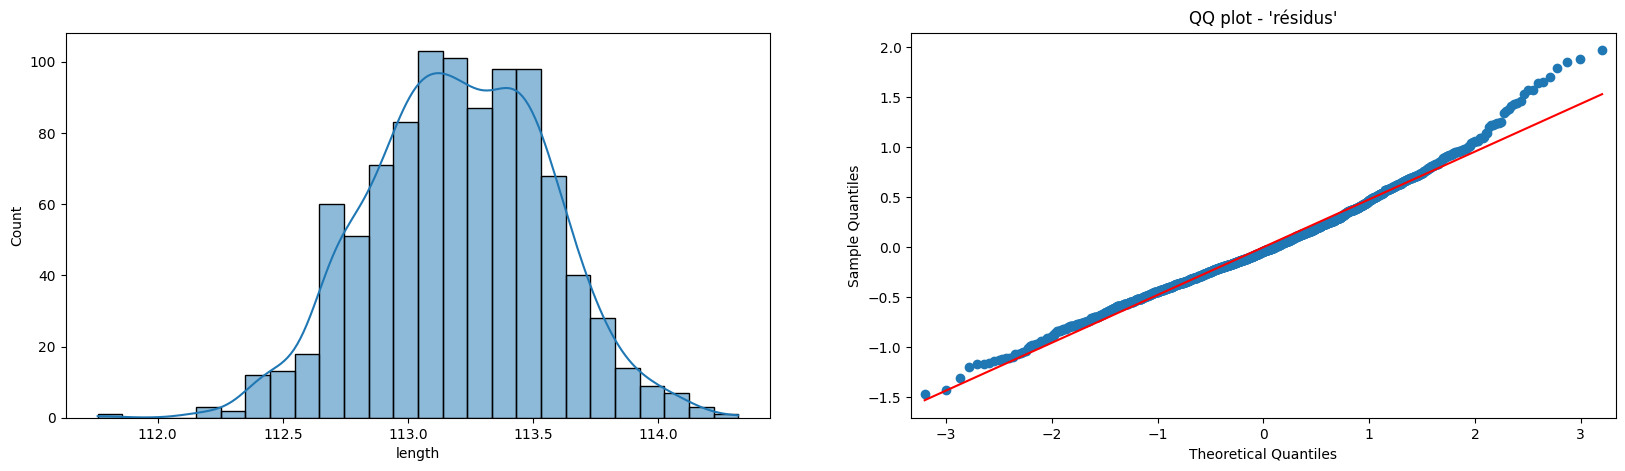

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.histplot(data = billets_true_nonan, x = i, kde = True, ax = ax[0], color = '#1f77b4')
sm.qqplot(residus, line = 'r', ax = ax[1])
ax[1].set_title("Distribution des résidus ")
ax[1].set_title("QQ plot - 'résidus'")
plt.show()

Léger écart à la normalité dans la distribution des résidus.

In [23]:
print(f"Skewness : {residus.skew()}")
print(f"Kurtosis : {residus.kurtosis()}")

Skewness : 0.48274751244148406
Kurtosis : 0.80830066501392


#### 2.3.4. Vérification de la non-autocorrélation des résidus : test de Durbin-Watson.

In [24]:
from statsmodels.stats.stattools import durbin_watson
# Durbin-Watson test
print(durbin_watson(residus))
print("Le résultat est très proche de 2 et suggère que la probalité d'une autocorrélation \
des résidus soit très faible.")

1.8927631665241558
Le résultat est très proche de 2 et suggère que la probalité d'une autocorrélation des résidus soit très faible.


#### 2.3.4. Test F (ANOVA)

In [25]:
print('F-statistic:', olsmod.fvalue)
print('Probability of observing value at least as high as F-statistic:', olsmod.f_pvalue)

F-statistic: 266.1290985577848
Probability of observing value at least as high as F-statistic: 2.60059481013516e-202


In [26]:
print(olsmod.pvalues)

const           1.736939e-02
diagonal        7.443859e-03
height_left     4.132146e-05
height_right    2.836546e-09
margin_up       7.233463e-05
length          2.183858e-97
dtype: float64


### 2.4. Remplacement des valeurs manquantes pour la variable 'margin_low'.

In [27]:
billets_no_nan_new = billets_nan.copy()
billets_no_nan_new = billets_no_nan_new.drop('is_genuine', axis = 1)
billets_no_nan_new = billets_no_nan_new.drop('margin_low', axis = 1)
index = billets_no_nan_new.index
index

Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')

In [28]:
# valeurs manquantes pour margin_low
#billets['margin_low_new'] = 'no'
#billets_test_logit = billets.loc[billets['margin_low_new'] == 'yes', :]
#billets_test_logit
predictions = model.predict(billets_no_nan_new)
resultats = pd.DataFrame(predictions, index = billets_no_nan_new.index)
resultats

0
72    4.318525
99    4.393668
151   4.410457
197   4.319014
241   4.650617
251   3.803308
284   4.179736
334   4.127442
410   4.135034
413   4.160539
445   4.177420
481   3.768554
505   4.058764
611   4.298047
654   4.160607
675   4.094065
710   4.439846
739   4.470650
742   4.341643
780   4.080414
798   3.614306
844   4.371811
845   4.093621
871   4.249629
895   3.893748
919   3.746333
945   4.237415
946   4.710533
981   4.137780
1076  5.050277
1121  4.802145
1176  5.067584
1303  5.047570
1315  4.778967
1347  5.726993
1435  5.185862
1438  5.140043

In [29]:
billets['margin_low_new'] =  'no'
billets.loc[(billets['margin_low'].isnull()), 'margin_low_new'] = 'yes'
billets.loc[(billets['margin_low_new'] == 'yes'), 'margin_low'] = resultats[0]
billets.loc[billets['margin_low_new'] == 'yes', :]
billets = billets.drop('margin_low_new', axis = 1)
billets

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [30]:
# skim(billets)
print(billets.info())
billets.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB
None


diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1500.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.483475     3.151473   
std       0.305195     0.299462      0.325627     0.659632     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.020000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

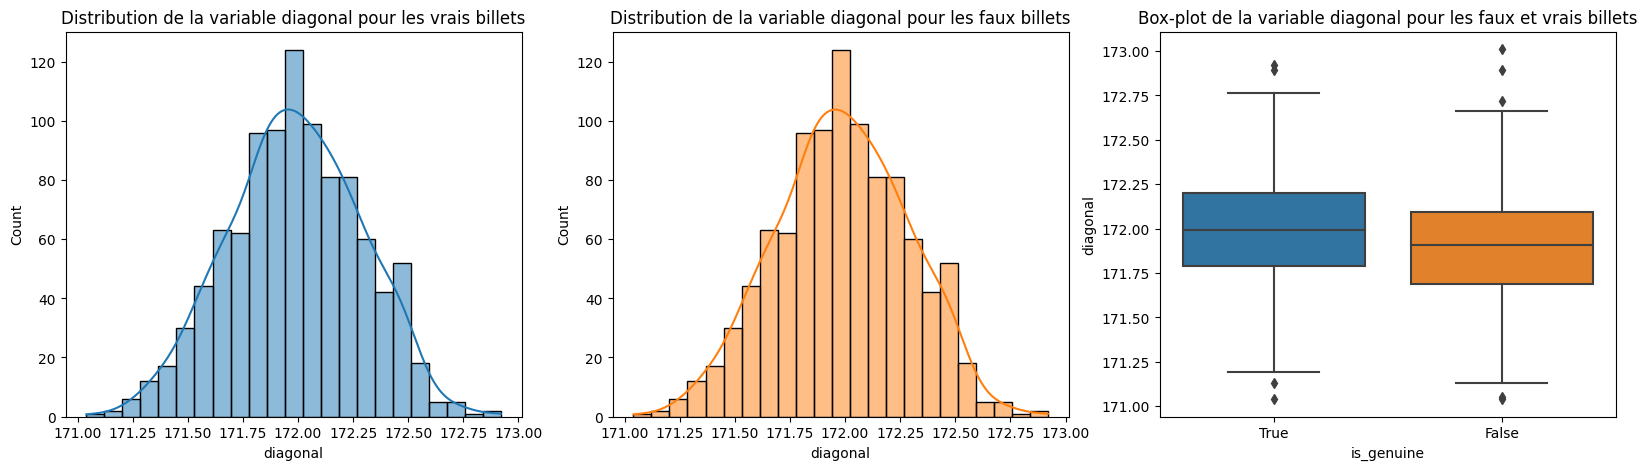

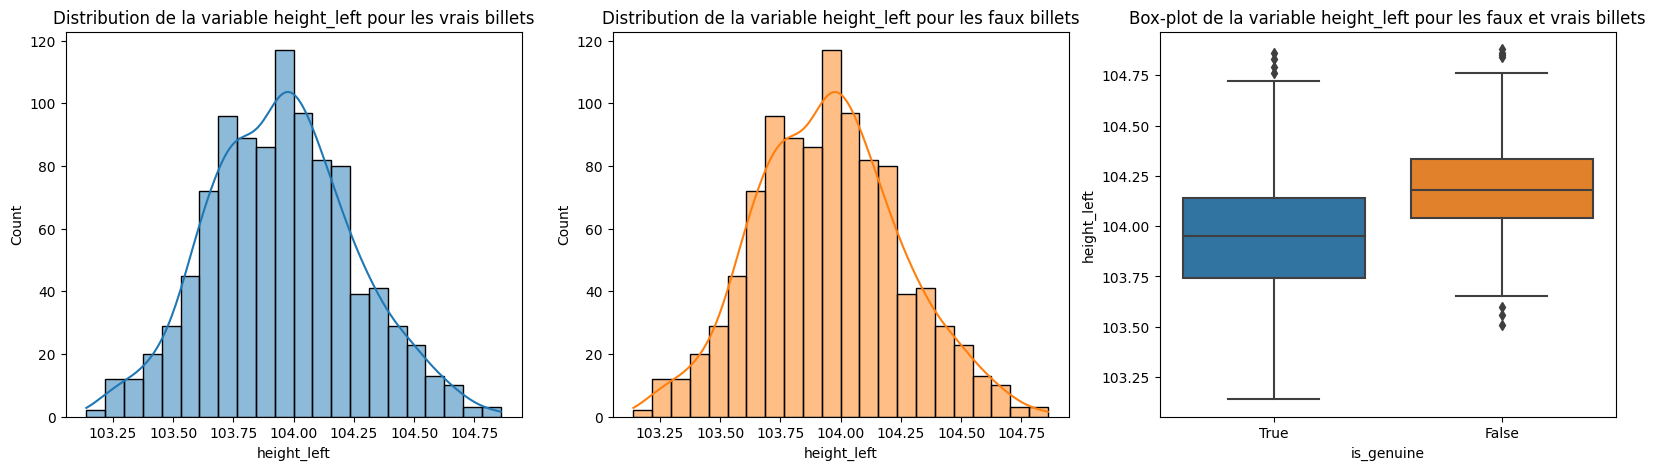

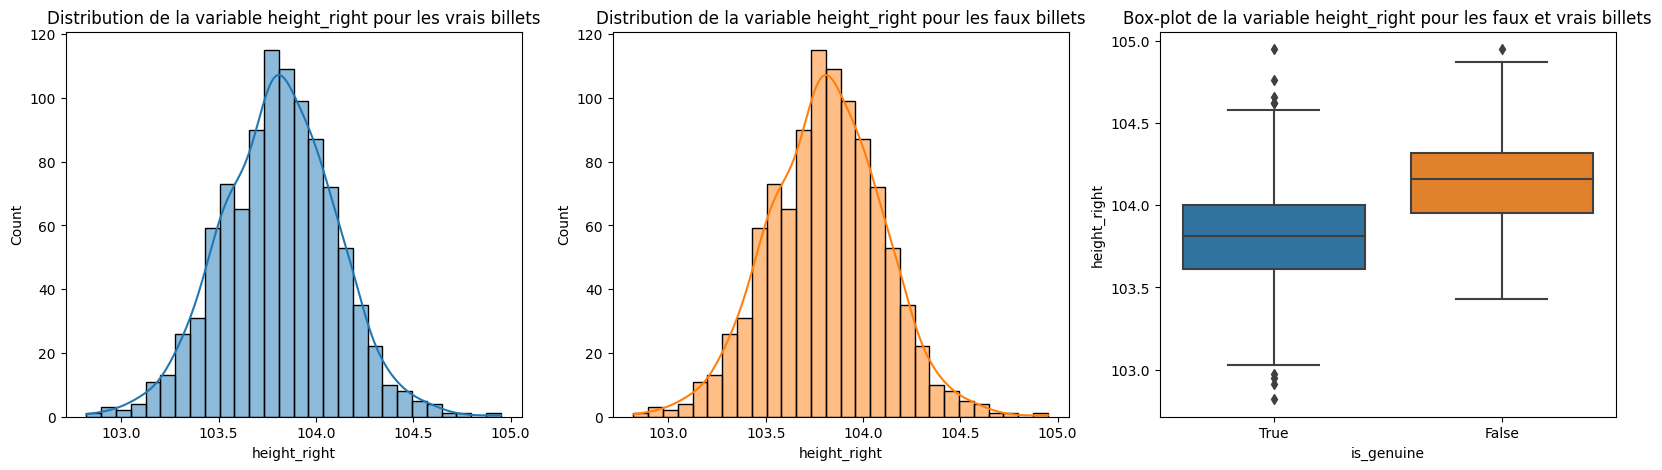

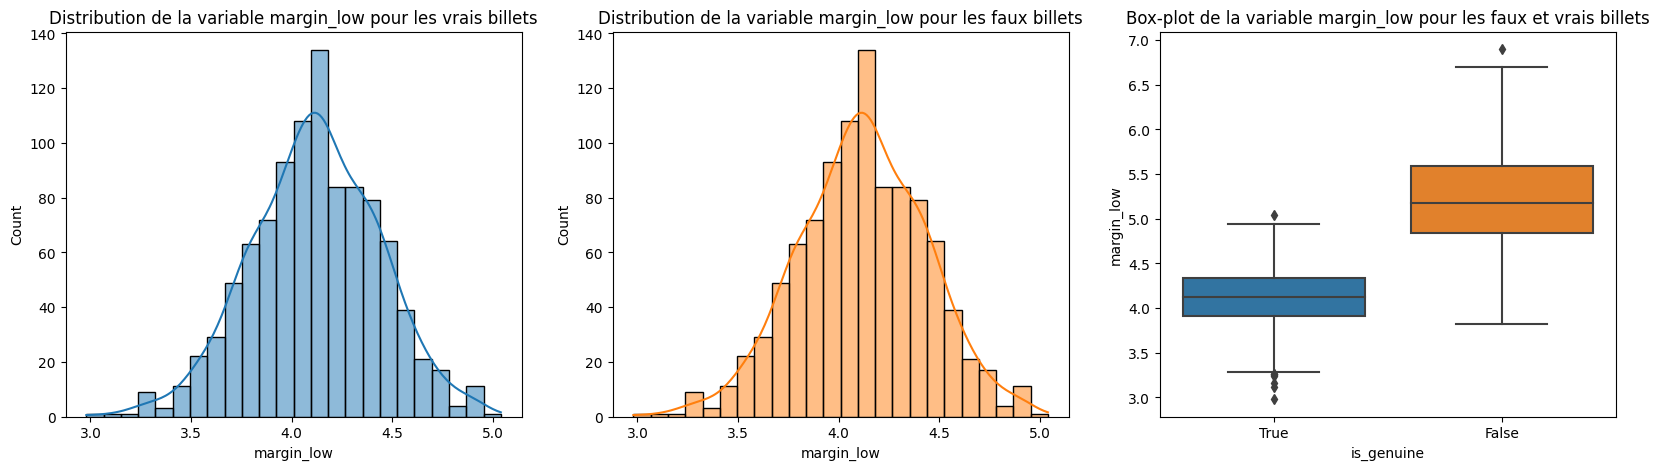

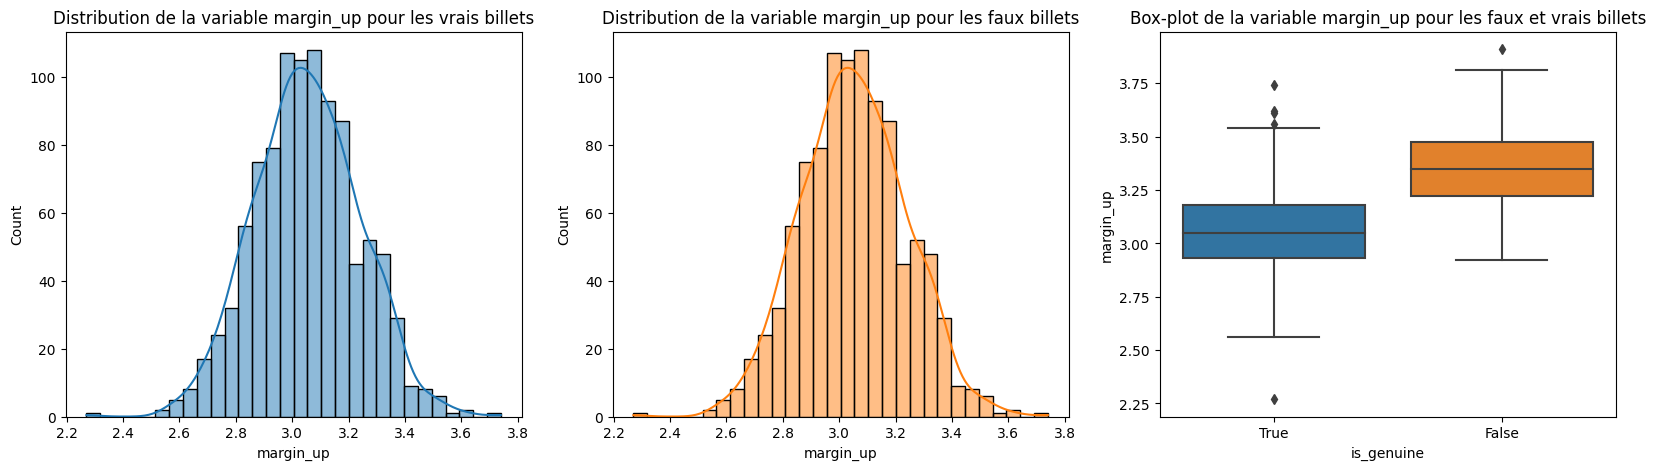

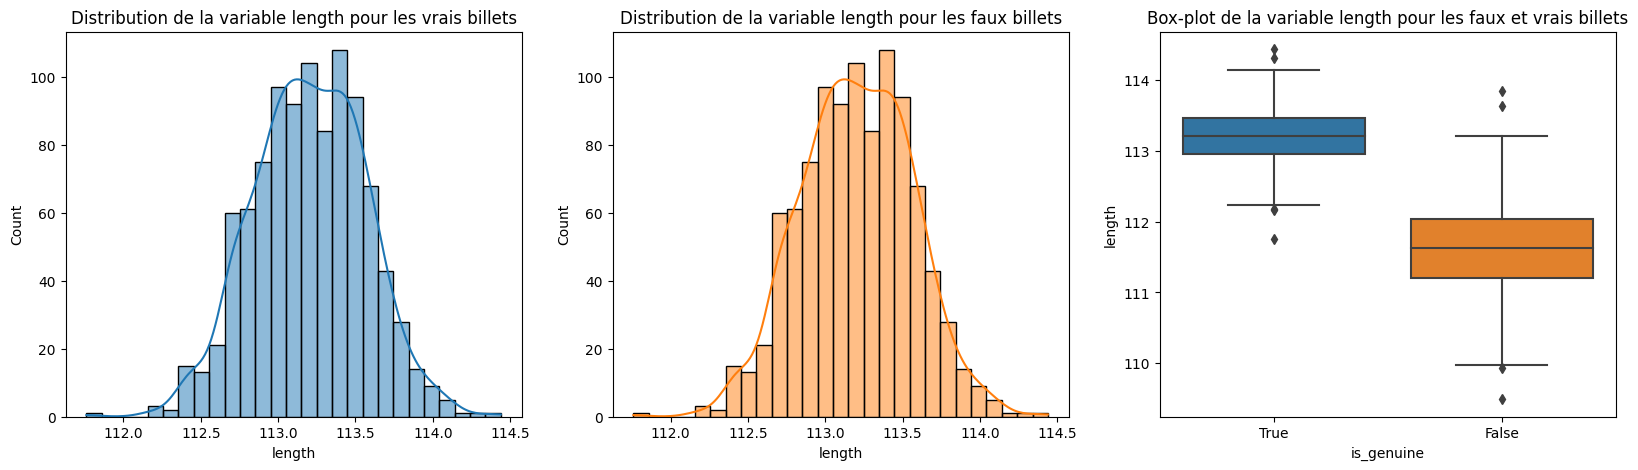

In [31]:
for i in billets:
    if i != 'is_genuine':
        fig, ax = plt.subplots(1, 3, figsize = (20, 5))
        ax[0].set_title("Distribution de la variable " + i + " pour les vrais billets")
        sns.histplot(data = billets.loc[billets['is_genuine'] == True, :], x = i, kde = True, ax = ax[0], color = '#1f77b4')
        ax[1].set_title("Distribution de la variable " + i + " pour les faux billets")
        sns.histplot(data = billets.loc[billets['is_genuine'] == True, :], x = i, kde = True, ax = ax[1], color = '#ff7f0e')
        ax[2].set_title("Box-plot de la variable " + i + " pour les faux et vrais billets")
        sns.boxplot(y = billets[i], x = billets["is_genuine"], order = (True, False), ax = ax[2])
        plt.show()

## 3. Entraînement d'un modèle de régression logistique classique.

In [32]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


### 3.1. Préparation de l'échantillon d'apprentissage.

In [33]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [34]:
# Y ('is_genuine') est la première colonne
YBillets = billets.iloc[:, 0]
# X (les autres) sont les variables des colonnes 1 à 7
XBillets = billets.iloc[:, 1:7]
# comptage des modalités de y
print(YBillets.value_counts())
XBillets
# séparation des données en deux groupes (30% test / 70 % entraînemt)
X_train, X_test, y_train, y_test = train_test_split(XBillets, YBillets, test_size = 0.3)

True     1000
False     500
Name: is_genuine, dtype: int64


### 3.2. Importation et préparation des données test.

In [35]:
# importation des données dans un dataframe "Pandas"
billets_test = pd.read_csv('billets_production.csv')
billets_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 408.0+ bytes


In [36]:
id = billets_test['id']
id

0    A_1
1    A_2
2    A_3
3    A_4
4    A_5
Name: id, dtype: object

In [37]:
# suppression de la colonne 'id'
XTest = billets_test.drop('id', axis = 1)
XTest

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.76       104.01        103.54        5.21       3.30  111.42
1    171.87       104.17        104.13        6.00       3.31  112.09
2    172.00       104.58        104.29        4.99       3.39  111.57
3    172.49       104.55        104.34        4.44       3.03  113.20
4    171.65       103.63        103.56        3.77       3.16  113.33

### 3.3. Régression logistique avec "statsmodels".

In [38]:
# importation de l'outil
from statsmodels.tools import add_constant
# données X avec la constante
X_test = sm.tools.add_constant(X_test, 1.0)
# vérifier la structure
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 938 to 1254
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         450 non-null    float64
 1   diagonal      450 non-null    float64
 2   height_left   450 non-null    float64
 3   height_right  450 non-null    float64
 4   margin_low    450 non-null    float64
 5   margin_up     450 non-null    float64
 6   length        450 non-null    float64
dtypes: float64(7)
memory usage: 28.1 KB
None


In [39]:
# visualisation des premières lignes de la structure
# premières lignes
print(X_test.head())

      const  diagonal  height_left  height_right  margin_low  margin_up  \
938     1.0    172.19       104.08        104.17        4.17       3.26   
196     1.0    171.99       103.98        103.73        4.34       3.20   
315     1.0    171.99       103.60        103.43        4.57       2.96   
1225    1.0    172.03       104.15        104.24        5.12       3.30   
728     1.0    171.94       104.11        104.16        4.08       3.35   

      length  
938   113.07  
196   113.05  
315   113.09  
1225  112.36  
728   111.76  


#### 3.3.1. Utilisation de l'algorithme de Newton-Raphson

In [40]:
# régression logistique - on passe la cible et les explicatives
lr = Logit(endog = y_test, exog = X_test)
# lancer les calculs
# algorithme de Newton-Raphson utilisé par défaut
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.037746
         Iterations 13


In [41]:
#résumé des résultats
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  450
Model:                          Logit   Df Residuals:                      443
Method:                           MLE   Df Model:                            6
Date:                Fri, 29 Sep 2023   Pseudo R-squ.:                  0.9401
Time:                        20:06:25   Log-Likelihood:                -16.986
converged:                       True   LL-Null:                       -283.58
Covariance Type:            nonrobust   LLR p-value:                5.947e-112
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          337.0362    421.027      0.801      0.423    -488.162    1162.234
diagonal        -2.7093      1.945     -1.393      0.164      -6.521       1.103
height_left     -2.2131      1.706     -1.29

In [42]:
#intervalle de confiance des coefficients à 90%
print(res.conf_int(alpha = 0.1))

                       0            1
const        -355.491756  1029.564056
diagonal       -5.908344     0.489756
height_left    -5.020015     0.593817
height_right   -3.568916     2.064446
margin_low     -9.539766    -3.709298
margin_up     -20.088218    -6.336179
length          2.761471     6.313477


#### 3.3.2. Matrice de confusion : détermination du % de faux positifs et de faux négatifs pour l'échantillon de test.

In [43]:
# valeurs estimées par la régression en resubstitution
print(res.fittedvalues)

938      4.179245
196      4.849209
315      7.744642
1225    -5.638241
728     -1.739283
          ...    
558      6.558658
838     15.428947
1133   -20.489926
1238   -17.575596
1254   -14.323905
Length: 450, dtype: float64


In [44]:
# Voici les coefficients estimés
print(res.params)

const           337.036150
diagonal         -2.709294
height_left      -2.213099
height_right     -0.752235
margin_low       -6.624532
margin_up       -13.212199
length            4.537474
dtype: float64


In [45]:
# voici la description du premier individu
print(X_test.iloc[0,:])

const             1.00
diagonal        172.19
height_left     104.08
height_right    104.17
margin_low        4.17
margin_up         3.26
length          113.07
Name: 938, dtype: float64


In [46]:
# et si on fait le produit scalaire – valeur du LOGIT pour l’individu n°0
print(np.sum(res.params*X_test.iloc[0,:]))

4.1792450018027125


In [47]:
# la règle d'affectation consiste à confronter le LOGIT à la valeur seuil 0
predResub = np.where(res.fittedvalues > 0, 1, 0)
print(predResub)

[1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1
 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1
 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0
 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1
 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0
 1 1 1 0 0 0]


In [48]:
# on peut en déduire la matrice de confusion
mat_conf = pd.crosstab(y_test,predResub)
print(mat_conf)

col_0         0    1
is_genuine          
False       143    3
True          1  303


In [49]:
# matrice de confusion en resubstitution directement fournie par l'outil
print(res.pred_table())

[[143.   3.]
 [  1. 303.]]


In [50]:
mcf = res.pred_table()
fp_fn(mcf)

% de faux positifs : 0.22 %
% de faux négatifs : 0.67 %
% d'efficacité : 99.11 %
% sensibilité : 99.02 %
% spécificité : 99.31 %


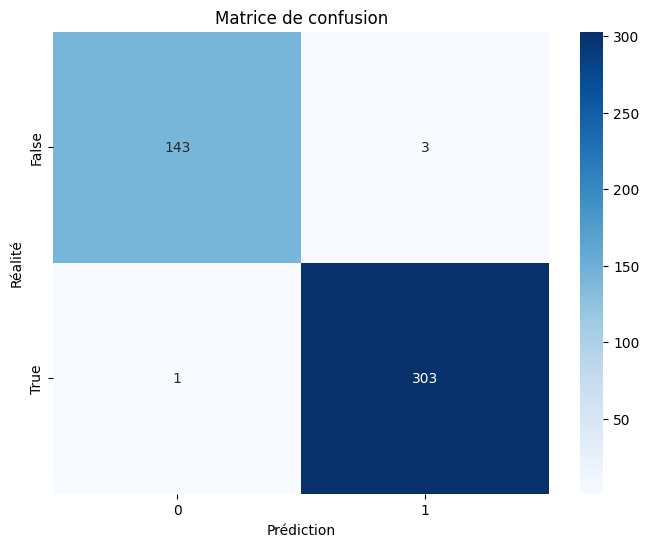

In [51]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(mat_conf, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.show()

#### 3.3.3. R² d'Efron

In [52]:
def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)

In [53]:
efron_rsquare(y_test, predResub)

0.9594448449891853

#### 3.3.4. Résumé de la modélisation

In [54]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                  450
Model:                          Logit   Df Residuals:                      443
Method:                           MLE   Df Model:                            6
Date:                Fri, 29 Sep 2023   Pseudo R-squ.:                  0.9401
Time:                        20:06:26   Log-Likelihood:                -16.986
converged:                       True   LL-Null:                       -283.58
Covariance Type:            nonrobust   LLR p-value:                5.947e-112
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          337.0362    421.027      0.801      0.423    -488.162    1162.234
diagonal        -2.7093      1.945     -1.393      0.164      -6.521       1.103
height_left     -2.2131      1.706     -1.297      0.195      -5.558       1.132
height_right    -0.7522      1.712     -0.439      0.660      -4.109       2.604
margin_low      -6.6245      1.772     -3.738      0.000     -10.098      -3.151
margin_up      -13.2122      4.180     -3.161      0.002     -21.405      -5.019
length           4.5375      1.080      4.202      0.000       2.421       6.654
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### 3.3.5. Test sur l'échantillon donné

In [55]:
# préparation de l'échantillon test
# par adjonction de la constante c
XTest_Bis = XTest.copy()
XTest_Bis = add_constant(XTest_Bis)
print(XTest_Bis.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         5 non-null      float64
 1   diagonal      5 non-null      float64
 2   height_left   5 non-null      float64
 3   height_right  5 non-null      float64
 4   margin_low    5 non-null      float64
 5   margin_up     5 non-null      float64
 6   length        5 non-null      float64
dtypes: float64(7)
memory usage: 408.0 bytes
None


In [56]:
# calcul de la prédiction sur l'échantillon test
predProbaSm2 = res.predict(XTest_Bis)
# à l'évidence nous avons les probabilités d'affectation
print(predProbaSm2.describe())

count    5.000000
mean     0.396568
std      0.542983
min      0.000004
25%      0.000029
50%      0.000132
75%      0.982681
max      0.999995
dtype: float64


In [57]:
# convertir en prédiction brute
predSm2 = np.where(predProbaSm2 > 0.5, 1, 0)
print(np.unique(predSm2,return_counts  =True))

(array([0, 1]), array([3, 2], dtype=int64))


In [58]:
predSm2

array([0, 0, 0, 1, 1])

In [59]:
predProbaSm2

0    0.000132
1    0.000004
2    0.000029
3    0.982681
4    0.999995
dtype: float64

In [60]:
XTest['id'] = id
XTest['is_genuine'] = predProbaSm2
XTest.loc[XTest['is_genuine'] > 0.5, 'is_genuine'] = "True"
XTest.loc[XTest['is_genuine'] != "True", 'is_genuine'] = "False"
XTest

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

  is_genuine  
0      False  
1      False  
2      False  
3       True  
4       True

#### 3.3.6. Application à l'ensemble des billets

In [61]:
#billets_test_bis = billets_test.drop('id', axis = 1)
billets_logit = billets.drop('is_genuine', axis = 1)
billets_logit = add_constant(billets_logit)
print(billets_logit.info())
billets_logit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         1500 non-null   float64
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(7)
memory usage: 82.2 KB
None


const  diagonal  height_left  height_right  margin_low  margin_up  \
0       1.0    171.81       104.86        104.95        4.52       2.89   
1       1.0    171.46       103.36        103.66        3.77       2.99   
2       1.0    172.69       104.48        103.50        4.40       2.94   
3       1.0    171.36       103.91        103.94        3.62       3.01   
4       1.0    171.73       104.28        103.46        4.04       3.48   
...     ...       ...          ...           ...         ...        ...   
1495    1.0    171.75       104.38        104.17        4.42       3.09   
1496    1.0    172.19       104.63        104.44        5.27       3.37   
1497    1.0    171.80       104.01        104.12        5.51       3.36   
1498    1.0    172.06       104.28        104.06        5.17       3.46   
1499    1.0    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [62]:
# calcul de la prédiction sur l'ensemble des billets
predProbaSm3 = res.predict(billets_logit)
# à l'évidence nous avons les probabilités d'affectation
print(predProbaSm3.describe())

count    1.500000e+03
mean     6.680014e-01
std      4.595701e-01
min      3.104820e-12
25%      1.928870e-03
50%      9.983676e-01
75%      9.999614e-01
max      1.000000e+00
dtype: float64


In [63]:
# convertir en prédiction brute
predSm3 = np.where(predProbaSm3 > 0.5, 1, 0)
print(np.unique(predSm3,return_counts  = True))

(array([0, 1]), array([ 492, 1008], dtype=int64))


In [64]:
predSm3
print(len(predSm3))

1500


In [65]:
predProbaSm3

0       9.875898e-01
1       9.999995e-01
2       9.961506e-01
3       9.999999e-01
4       7.439558e-01
            ...     
1495    5.600219e-02
1496    1.836772e-07
1497    5.265665e-05
1498    1.483006e-04
1499    5.733506e-02
Length: 1500, dtype: float64

In [66]:
billets_logit['is_genuine'] = predProbaSm3
billets_logit.loc[billets_logit['is_genuine'] > 0.5, 'is_genuine'] = "True"
billets_logit.loc[billets_logit['is_genuine'] != "True", 'is_genuine'] = "False"
billets_logit

const  diagonal  height_left  height_right  margin_low  margin_up  \
0       1.0    171.81       104.86        104.95        4.52       2.89   
1       1.0    171.46       103.36        103.66        3.77       2.99   
2       1.0    172.69       104.48        103.50        4.40       2.94   
3       1.0    171.36       103.91        103.94        3.62       3.01   
4       1.0    171.73       104.28        103.46        4.04       3.48   
...     ...       ...          ...           ...         ...        ...   
1495    1.0    171.75       104.38        104.17        4.42       3.09   
1496    1.0    172.19       104.63        104.44        5.27       3.37   
1497    1.0    171.80       104.01        104.12        5.51       3.36   
1498    1.0    172.06       104.28        104.06        5.17       3.46   
1499    1.0    171.47       104.15        103.82        4.63       3.37   

      length is_genuine  
0     112.83       True  
1     113.09       True  
2     113.16       True  
3     113.51       True  
4     112.54       True  
...      ...        ...  
1495  111.28      False  
1496  110.97      False  
1497  111.95      False  
1498  112.25      False  
1499  112.07      False  

[1500 rows x 8 columns]

### 3.3.7. Matrice de confusion : détermination du % de faux positifs et de faux négatifs pour l'ensemble des billets.

In [67]:
realite = billets['is_genuine'].astype('int').to_numpy()
prediction = billets_logit.copy()
prediction.loc[prediction['is_genuine'] == 'True', 'is_genuine'] = 1
prediction.loc[prediction['is_genuine'] == 'False', 'is_genuine'] = 0
prediction = prediction['is_genuine'].astype('int').to_numpy()
prediction

array([1, 1, 1, ..., 0, 0, 0])

In [68]:
confusion_matrix = metrics.confusion_matrix(realite, prediction)

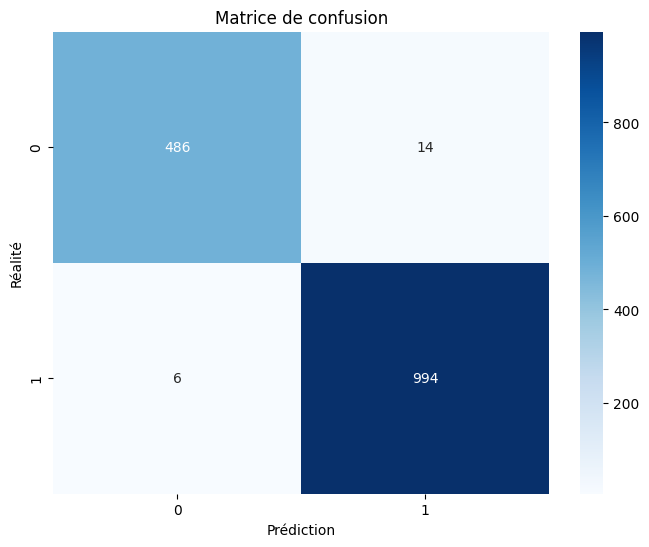

In [69]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.show()

In [70]:
confusion_matrix

array([[486,  14],
       [  6, 994]], dtype=int64)

In [71]:
mcf = confusion_matrix
fp_fn(mcf)

% de faux positifs : 0.4 %
% de faux négatifs : 0.93 %
% d'efficacité : 98.67 %
% sensibilité : 98.61 %
% spécificité : 98.78 %


## 4. Clusterisation via "k-means".

In [72]:
billets_kmeans = billets.copy()
is_genuine = billets_kmeans['is_genuine']
billets_kmeans = billets.drop('is_genuine', axis = 1)

random.seed(10)
kmeans = KMeans(n_clusters = 2, init = 'random', max_iter = 30).fit_predict(billets_kmeans)

labels = pd.Series(kmeans)
clusters = labels.to_frame()
clusters = clusters.rename(columns = {0:'clusters'})

billets_kmeans = pd.merge(billets_kmeans, clusters, left_index = True, right_index = True)
billets_kmeans['is_genuine'] = is_genuine

billets_kmeans

C:\Users\guill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


diagonal  height_left  height_right  margin_low  margin_up  length  \
0       171.81       104.86        104.95        4.52       2.89  112.83   
1       171.46       103.36        103.66        3.77       2.99  113.09   
2       172.69       104.48        103.50        4.40       2.94  113.16   
3       171.36       103.91        103.94        3.62       3.01  113.51   
4       171.73       104.28        103.46        4.04       3.48  112.54   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      clusters  is_genuine  
0            1        True  
1            1        True  
2            1        True  
3            1        True  
4            1        True  
...        ...         ...  
1495         0       False  
1496         0       False  
1497         0       False  
1498         0       False  
1499         0       False  

[1500 rows x 8 columns]

### 4.1. Clusters 1/0 et vrais/faux billets. 

In [73]:
clust_is_gen = billets_kmeans.copy()
clust_is_gen = clust_is_gen[['is_genuine', 'clusters']]
clust_is_gen = clust_is_gen.groupby(['clusters']).count()
clust_is_gen = clust_is_gen.reset_index() 
# on fait la supposition qu'il y a plus de vrais billets que de faux
if clust_is_gen.iloc[1, 1] < clust_is_gen.iloc[0, 1]:
    clust_is_gen.iloc[1, 0] = False
    clust_is_gen.iloc[0, 0] = True
else: 
    clust_is_gen.iloc[1, 0] = True
    clust_is_gen.iloc[0, 0] = False
clust_is_gen

clusters  is_genuine
0    False         484
1     True        1016

In [74]:
clust_true = clust_is_gen.loc[clust_is_gen['clusters'] == 1 ].index.astype('int')[0]
clust_false = clust_is_gen.loc[clust_is_gen['clusters'] == 0 ].index.astype('int')[0]
print(f'La méthode kmeans reconnait {clust_is_gen.iloc[clust_true,1]} \
vrais billets et {clust_is_gen.iloc[clust_false,1]} faux billets.')

La méthode kmeans reconnait 1016 vrais billets et 484 faux billets.


In [75]:
clust_true

1

In [76]:
# on attribue le cluster 1 aux vrais billets
billets_kmeans.loc[(billets_kmeans['clusters'] == clust_true), 'cluster_bool'] = True
billets_kmeans.loc[(billets_kmeans['clusters'] == clust_false), 'cluster_bool'] = False
billets_kmeans.loc[(billets_kmeans['cluster_bool'] == 1), 'clusters'] = 1
billets_kmeans.loc[(billets_kmeans['cluster_bool'] == 0), 'clusters'] = 0
billets_kmeans

diagonal  height_left  height_right  margin_low  margin_up  length  \
0       171.81       104.86        104.95        4.52       2.89  112.83   
1       171.46       103.36        103.66        3.77       2.99  113.09   
2       172.69       104.48        103.50        4.40       2.94  113.16   
3       171.36       103.91        103.94        3.62       3.01  113.51   
4       171.73       104.28        103.46        4.04       3.48  112.54   
...        ...          ...           ...         ...        ...     ...   
1495    171.75       104.38        104.17        4.42       3.09  111.28   
1496    172.19       104.63        104.44        5.27       3.37  110.97   
1497    171.80       104.01        104.12        5.51       3.36  111.95   
1498    172.06       104.28        104.06        5.17       3.46  112.25   
1499    171.47       104.15        103.82        4.63       3.37  112.07   

      clusters  is_genuine cluster_bool  
0            1        True         True  
1            1        True         True  
2            1        True         True  
3            1        True         True  
4            1        True         True  
...        ...         ...          ...  
1495         0       False        False  
1496         0       False        False  
1497         0       False        False  
1498         0       False        False  
1499         0       False        False  

[1500 rows x 9 columns]

### 4.2. Matrice de confusion : détermination du % de faux positifs et de faux négatifs.

In [77]:
realite = billets['is_genuine'].astype('int').to_numpy()
prediction = billets_kmeans['clusters'].to_numpy().astype('int')
prediction

array([1, 1, 1, ..., 0, 0, 0])

In [78]:
confusion_matrix_2 = metrics.confusion_matrix(realite, prediction)

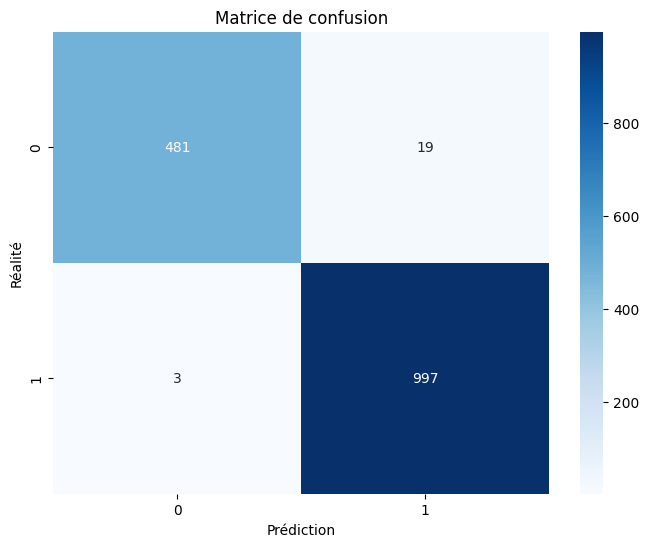

In [79]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_2, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.show()

In [80]:
confusion_matrix_2

array([[481,  19],
       [  3, 997]], dtype=int64)

In [81]:
mcf = confusion_matrix_2
fp_fn(mcf)
mcf.sum()

% de faux positifs : 0.2 %
% de faux négatifs : 1.27 %
% d'efficacité : 98.53 %
% sensibilité : 98.13 %
% spécificité : 99.38 %


1500

## 5. Comparaison des 2 méthodes de prédiction (régression logistique et partitionnement "k-means").

In [82]:
billets_resultats = billets.copy()
billets_resultats['kmeans'] = billets_kmeans['clusters']
billets_resultats['logit'] = billets_logit['is_genuine']

billets_resultats = billets_resultats[['is_genuine', 'kmeans', 'logit']]
billets_resultats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   is_genuine  1500 non-null   bool  
 1   kmeans      1500 non-null   int32 
 2   logit       1500 non-null   object
dtypes: bool(1), int32(1), object(1)
memory usage: 19.2+ KB


In [83]:
billets_resultats['logit_pts'] = 0 
billets_resultats['kmean_pts'] = 0 
billets_resultats.loc[(billets_resultats['is_genuine'] == 1) & (billets_resultats['kmeans'] == 1), 'kmean_pts'] = 1
billets_resultats.loc[(billets_resultats['is_genuine'] == 0) & (billets_resultats['kmeans'] == 0), 'kmean_pts'] = 1
billets_resultats.loc[(billets_resultats['is_genuine'] == 1) & (billets_resultats['logit'] == "True"), 'logit_pts'] = 1
billets_resultats.loc[(billets_resultats['is_genuine'] == 0) & (billets_resultats['logit'] == "False"), 'logit_pts'] = 1
billets_resultats

is_genuine  kmeans  logit  logit_pts  kmean_pts
0           True       1   True          1          1
1           True       1   True          1          1
2           True       1   True          1          1
3           True       1   True          1          1
4           True       1   True          1          1
...          ...     ...    ...        ...        ...
1495       False       0  False          1          1
1496       False       0  False          1          1
1497       False       0  False          1          1
1498       False       0  False          1          1
1499       False       0  False          1          1

[1500 rows x 5 columns]

In [84]:
billets_resultats['logit_pts'] = 0 
billets_resultats['kmean_pts'] = 0 
billets_resultats.loc[(billets_resultats['is_genuine'] == 1) & (billets_resultats['kmeans'] == 1), 'kmean_pts'] = 1
billets_resultats.loc[(billets_resultats['is_genuine'] == 0) & (billets_resultats['kmeans'] == 0), 'kmean_pts'] = 1
billets_resultats.loc[(billets_resultats['is_genuine'] == 1) & (billets_resultats['logit'] == "True"), 'logit_pts'] = 1
billets_resultats.loc[(billets_resultats['is_genuine'] == 0) & (billets_resultats['logit'] == "False"), 'logit_pts'] = 1
billets_resultats

is_genuine  kmeans  logit  logit_pts  kmean_pts
0           True       1   True          1          1
1           True       1   True          1          1
2           True       1   True          1          1
3           True       1   True          1          1
4           True       1   True          1          1
...          ...     ...    ...        ...        ...
1495       False       0  False          1          1
1496       False       0  False          1          1
1497       False       0  False          1          1
1498       False       0  False          1          1
1499       False       0  False          1          1

[1500 rows x 5 columns]

In [85]:
score_logit = billets_resultats['logit_pts'].sum()
score_kmeans = billets_resultats['kmean_pts'].sum()

In [86]:
print(f'Score Logit : {score_logit} billets correctements vérifiés.')
print(f'Score kmeans : {score_kmeans} billets correctement vérifiés.')

Score Logit : 1480 billets correctements vérifiés.
Score kmeans : 1478 billets correctement vérifiés.


#### Erreurs de détection Logit

In [87]:
display(billets_resultats.loc[(billets_resultats['is_genuine'] == 1) & (billets_resultats['logit'] == "False")])
display(billets_resultats.loc[(billets_resultats['is_genuine'] == 0) & (billets_resultats['logit'] == "True")])

is_genuine  kmeans  logit  logit_pts  kmean_pts
6          True       1  False          0          1
193        True       1  False          0          1
341        True       1  False          0          1
591        True       0  False          0          0
626        True       1  False          0          1
728        True       0  False          0          0

is_genuine  kmeans logit  logit_pts  kmean_pts
1025       False       1  True          0          0
1062       False       0  True          0          1
1073       False       1  True          0          0
1083       False       1  True          0          0
1084       False       0  True          0          1
1103       False       1  True          0          0
1122       False       1  True          0          0
1160       False       1  True          0          0
1190       False       1  True          0          0
1362       False       0  True          0          1
1383       False       0  True          0          1
1388       False       0  True          0          1
1407       False       1  True          0          0
1412       False       1  True          0          0

#### Erreurs de détection kmeans

In [88]:
display(billets_resultats.loc[(billets_resultats['is_genuine'] == 1) & (billets_resultats['kmeans'] == 0)])
display(billets_resultats.loc[(billets_resultats['is_genuine'] == 0) & (billets_resultats['kmeans'] == 1)])

is_genuine  kmeans  logit  logit_pts  kmean_pts
241        True       0   True          1          0
591        True       0  False          0          0
728        True       0  False          0          0

is_genuine  kmeans  logit  logit_pts  kmean_pts
1024       False       1  False          1          0
1025       False       1   True          0          0
1073       False       1   True          0          0
1078       False       1  False          1          0
1081       False       1  False          1          0
1083       False       1   True          0          0
1087       False       1  False          1          0
1103       False       1   True          0          0
1122       False       1   True          0          0
1160       False       1   True          0          0
1190       False       1   True          0          0
1223       False       1  False          1          0
1245       False       1  False          1          0
1270       False       1  False          1          0
1325       False       1  False          1          0
1341       False       1  False          1          0
1407       False       1   True          0          0
1412       False       1   True          0          0
1452       False       1  False          1          0

## 6. Utilisation d'une fonction destinée à l'identification automatisée des vrais et faux billets.

In [89]:
detection('Classeur1.csv')

Résultats obtenus par régression logistique.


diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1   
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2   
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3   
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4   
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5   

  is_genuine         logit  
0       True  9.983446e-01  
1      False  3.214058e-03  
2       True  9.999673e-01  
3      False  8.599168e-07  
4      False  1.992014e-02

Résultats obtenus par clusterisation k-means.


C:\Users\guill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1   
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2   
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3   
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4   
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5   

   is_genuine  clusters  
0        True         1  
1       False         0  
2        True         1  
3       False         0  
4       False         0

## Annexes

##### Billets "borderline" selon prédiction Logit.

In [90]:
# on ilsole les logit compris entre 0.6 et 0.4
billets_logit['logit'] = predProbaSm3
billets_logit.loc[(billets_logit['logit'] < 0.61) & (billets_logit['logit'] > 0.39)]

const  diagonal  height_left  height_right  margin_low  margin_up  \
6       1.0    172.34       104.18        103.85    4.580000       3.26   
341     1.0    171.90       104.21        104.21    4.770000       3.38   
344     1.0    172.53       103.97        103.28    4.610000       3.41   
626     1.0    171.98       104.44        104.08    4.670000       3.21   
743     1.0    172.30       104.58        104.17    4.360000       3.33   
946     1.0    171.63       103.87        104.66    4.710533       3.27   
975     1.0    172.43       104.04        104.26    4.560000       3.24   
1010    1.0    171.43       103.85        103.94    4.370000       3.23   
1062    1.0    171.65       104.19        103.96    5.370000       2.99   
1084    1.0    171.94       104.27        103.94    4.460000       3.14   
1121    1.0    171.40       104.38        104.19    4.802145       3.17   
1160    1.0    172.39       104.05        104.32    4.130000       3.41   
1362    1.0    171.56       103.80        103.87    5.660000       2.98   

      length is_genuine     logit  
6     112.81      False  0.474137  
341   113.20      False  0.419905  
344   113.25       True  0.522768  
626   112.73      False  0.456308  
743   112.98       True  0.545570  
946   112.68       True  0.576908  
975   112.82       True  0.524018  
1010  111.71      False  0.455327  
1062  112.86       True  0.555218  
1084  112.13       True  0.502054  
1121  112.39      False  0.390922  
1160  112.66       True  0.503433  
1362  112.95       True  0.503951

##### Méthode k-means appliquées aux 1505 billets

In [91]:
# partitionnement des 1500 billets en m^me temps que l'échantillon de test
billets_kmeans_2 = billets.copy()
is_genuine_2 = billets_kmeans_2['is_genuine']
billets_kmeans_2 = billets_kmeans_2.drop('is_genuine', axis = 1)

id = billets_test['id']
test_2 = billets_test.drop('id', axis = 1)
billets_kmeans_2 = pd.concat([billets_kmeans_2, test_2])

random.seed(10)
kmeans = KMeans(n_clusters = 2, init = 'random', max_iter = 30).fit_predict(billets_kmeans_2)
billets_kmeans_2['is_genuine'] = False
billets_kmeans_2['is_genuine'] = is_genuine_2
billets_kmeans_2['cluster'] = 0
labels = pd.Series(kmeans)
billets_kmeans_2['cluster'] = labels

billets_kmeans_2

C:\Users\guill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


diagonal  height_left  height_right  margin_low  margin_up  length  \
0     171.81       104.86        104.95        4.52       2.89  112.83   
1     171.46       103.36        103.66        3.77       2.99  113.09   
2     172.69       104.48        103.50        4.40       2.94  113.16   
3     171.36       103.91        103.94        3.62       3.01  113.51   
4     171.73       104.28        103.46        4.04       3.48  112.54   
..       ...          ...           ...         ...        ...     ...   
0     171.76       104.01        103.54        5.21       3.30  111.42   
1     171.87       104.17        104.13        6.00       3.31  112.09   
2     172.00       104.58        104.29        4.99       3.39  111.57   
3     172.49       104.55        104.34        4.44       3.03  113.20   
4     171.65       103.63        103.56        3.77       3.16  113.33   

    is_genuine  cluster  
0         True        0  
1         True        0  
2         True        0  
3         True        0  
4         True        0  
..         ...      ...  
0         True        0  
1         True        0  
2         True        0  
3         True        0  
4         True        0  

[1505 rows x 8 columns]

In [92]:
clust_is_gen_2 = billets_kmeans_2.copy()
clust_is_gen_2 = clust_is_gen_2[['is_genuine', 'cluster']]
clust_is_gen_2 = clust_is_gen_2.groupby(['cluster']).count()
clust_is_gen_2 = clust_is_gen_2.reset_index() 
# on fait la supposition qu'il y a plus de vrais billets que de faux
if clust_is_gen_2.iloc[1, 1] < clust_is_gen_2.iloc[0, 1]:
    clust_is_gen_2.iloc[1, 0] = False
    clust_is_gen_2.iloc[0, 0] = True
else: 
    clust_is_gen_2.iloc[1, 0] = True
    clust_is_gen_2.iloc[0, 0] = False
clust_is_gen_2

cluster  is_genuine
0    True        1021
1   False         484

In [93]:
clust_true_2 = clust_is_gen_2.loc[clust_is_gen_2['cluster'] == 1 ].index.astype('int')[0]
clust_false_2 = clust_is_gen_2.loc[clust_is_gen_2['cluster'] == 0 ].index.astype('int')[0]
print(f'La méthode kmeans reconnait {clust_is_gen.iloc[clust_true,1]} \
vrais billets et {clust_is_gen.iloc[clust_false,1]} faux billets.')

La méthode kmeans reconnait 1016 vrais billets et 484 faux billets.


In [94]:
clust_true_2

0

In [95]:
# on attribue le cluster 1 aux vrais billets
billets_kmeans_2.loc[(billets_kmeans_2['cluster'] == clust_true_2), 'cluster_bool'] = True
billets_kmeans_2.loc[(billets_kmeans_2['cluster'] == clust_false_2), 'cluster_bool'] = False
billets_kmeans_2.loc[(billets_kmeans_2['cluster_bool'] == 1), 'cluster'] = 1
billets_kmeans_2.loc[(billets_kmeans_2['cluster_bool'] == 0), 'cluster'] = 0
billets_kmeans_2

diagonal  height_left  height_right  margin_low  margin_up  length  \
0     171.81       104.86        104.95        4.52       2.89  112.83   
1     171.46       103.36        103.66        3.77       2.99  113.09   
2     172.69       104.48        103.50        4.40       2.94  113.16   
3     171.36       103.91        103.94        3.62       3.01  113.51   
4     171.73       104.28        103.46        4.04       3.48  112.54   
..       ...          ...           ...         ...        ...     ...   
0     171.76       104.01        103.54        5.21       3.30  111.42   
1     171.87       104.17        104.13        6.00       3.31  112.09   
2     172.00       104.58        104.29        4.99       3.39  111.57   
3     172.49       104.55        104.34        4.44       3.03  113.20   
4     171.65       103.63        103.56        3.77       3.16  113.33   

    is_genuine  cluster cluster_bool  
0         True        1         True  
1         True        1         True  
2         True        1         True  
3         True        1         True  
4         True        1         True  
..         ...      ...          ...  
0         True        1         True  
1         True        1         True  
2         True        1         True  
3         True        1         True  
4         True        1         True  

[1505 rows x 9 columns]

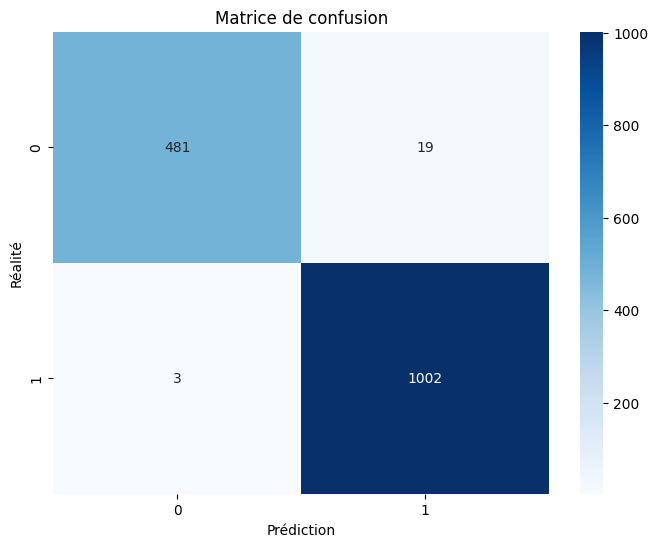

In [96]:
realite = billets_kmeans_2['is_genuine'].astype('int').to_numpy()
prediction = billets_kmeans_2['cluster'].to_numpy().astype('int')
confusion_matrix_3 = metrics.confusion_matrix(realite, prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_3, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.show()

In [97]:
mcf = confusion_matrix_3
fp_fn(mcf)
mcf.sum()

% de faux positifs : 0.2 %
% de faux négatifs : 1.26 %
% d'efficacité : 98.54 %
% sensibilité : 98.14 %
% spécificité : 99.38 %


1505

In [98]:
# affichage des résultats pour les billets test (issus de 'billets_production.csv')
billets_kmeans_2_test = billets_kmeans_2.tail().copy()
billets_kmeans_2_test.loc[billets_kmeans_2_test['is_genuine'] == 1, 'cluster'] = 1
billets_kmeans_2_test.loc[billets_kmeans_2_test['is_genuine'] == 0, 'cluster'] = 0
billets_kmeans_2_test

diagonal  height_left  height_right  margin_low  margin_up  length  \
0    171.76       104.01        103.54        5.21       3.30  111.42   
1    171.87       104.17        104.13        6.00       3.31  112.09   
2    172.00       104.58        104.29        4.99       3.39  111.57   
3    172.49       104.55        104.34        4.44       3.03  113.20   
4    171.65       103.63        103.56        3.77       3.16  113.33   

   is_genuine  cluster cluster_bool  
0        True        1         True  
1        True        1         True  
2        True        1         True  
3        True        1         True  
4        True        1         True